In [1]:
import numpy as np
from Bio import Entrez, SeqIO

In [2]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys
sys.path.append(".")

Let's let the nice folks at NCBI know who we are.

In [3]:
Entrez.email = "jb9255@fri.uni-lj.si"

# Phylogenetic analysis of coronaviruses

In the first part of the homework, you will conduct a phylogenetic analysis of a handful of coronaviruses. You will look at the similarity between the DNA sequences of these viruses to determine how closely related they are to one another. This might give us some insight into how these viruses might have evolved through time, or from which species SARS-CoV-2 jumped to us, humans.

We will build a phylogenetic tree in two steps. First, we will calculate the distances between each pair of viral genomes. We can't just compare them directly, we have to align them first. So we will run global alignment to get an optimal alignment between each pair of viral genomes. Then, we will calculate the distance between these alignments using Hamming distance. This just checks the number of symbols in the two sequences which do not match. Having calculated all pairwise distances, we can build a dendrogram, which will serve as our phylogenetic tree.

**A note on runtime:** To build a phylogenetic tree, you will need to calculate all pairwise distances between several coronavirus genomes. As you have learned in lectures, computing an alignment between two sequences of length $N$ and $M$ requires forming and calculating a table of $N \cdot M$ entries. This is fine for small sequences, but genomes, even short ones like viral genomes, are generally too long for this. For this reason, we will not calculate pairwise alignments between complete viral genomes in our analysis, but we will focus on the spike protein sequence only. The spike protein is one of the most important parts of any virus, as it is the one that grants the virus entry to host cells. Also, doing so will reduce the sequence lengths from ~30k to around 1.3k, which is much more manageable. Even so, do your best to write fast, efficient Python code, as you will spend a long time waiting for your programs to complete otherwise.

**Speeding things up**: On my laptop, each `global_alignment` call on 1.3k long protein sequences takes around 30 seconds. We have to calculate 210 comparisons, which takes roughly two hours. For those of you who want to speed things up and play around with several parameter settings, you can take advantage of *numba*. *numba* is a Python JIT library, which compiles your code and makes it run faster. We will make *numba* available in the grading environment for this homework. This is not a requirement or even a recommendation, because *numba* can be a pain to work with. However, you are welcome to take advantage of this if you so wish.

In [4]:
accession_codes = {
    # 7 known human coronaviruses
    "Human-SARS-CoV-2": "NC_045512",
    "Human-SARS": "NC_004718",
    "Human-MERS": "NC_019843",
    "Human-HCoV-OC43": "NC_006213",
    "Human-HCoV-229E": "NC_002645",
    "Human-HCoV-NL63": "NC_005831",
    "Human-HCoV-HKU1": "NC_006577",
    
    # Bat
    "Bat-CoV MOP1": "EU420138",
    "Bat-CoV HKU8": "NC_010438",
    "Bat-CoV HKU2": "NC_009988",
    "Bat-CoV HKU5": "NC_009020",
    "Bat-CoV RaTG13": "MN996532",
    "Bat-CoV-ENT": "NC_003045",
    
    # Other animals
    "Hedgehog-CoV 2012-174/GER/2012": "NC_039207",
    "Pangolin-CoV MP789": "MT121216",
    "Rabbit-CoV HKU14": "NC_017083",
    "Duck-CoV isolate DK/GD/27/2014": "NC_048214",
    "Feline infectious peritonitis virus": "NC_002306",  # cat
    "Giraffe-CoV US/OH3/2003": "EF424623",
    "Murine-CoV MHV/BHKR_lab/USA/icA59_L94P/2012": "KF268338",  # mouse
    "Equine-CoV Obihiro12-2": "LC061274",  # horse
}

Here is the list of viruses and their accession codes that we will be working with in this homework. As mentioned in _a note on runtime_, we won't be using the entire sequence to infer phylogenies, but we'll only look at the spike protein. To get spike protein regions from a `SeqRecord` object, we have to inspect the `features` field of each record. Look through the gene coding regions (CDS) of each sequence and find the region that codes for the "S" gene. Some records won't have this field, so look for "spike protein" in the `product` field.

In [5]:
# TODO: DONE
# 1. load sequences
# 2. extract spike protein regions
# 3. convert to amino-acid sequences
acid_seq = ['' for y in range(len(accession_codes))]
i = 0
for virus in accession_codes:
    with Entrez.efetch(db="nucleotide", id=accession_codes[virus], rettype="gb") as handle:
        data = SeqIO.read(handle, "genbank")
    for feature in data.features:
        if feature.type == 'CDS':
            if ('gene' in feature.qualifiers and feature.qualifiers['gene'][0] == 'S') or 'spike' in feature.qualifiers['product'][0]:
                acid_seq[i] = feature.qualifiers['translation'][0]
    i += 1      

## Problem 1

**TASK:**
Implement the Needleman-Wunsch algorithm you learned about in lectures for global sequence alignment in the `global_alignment` functions in `helper_functions.py`. **[10 points]**

Once you have implemented global sequence alignment, proceed to Problem 2.

In [6]:
from helper_functions import global_alignment

## Problem 2

**TASK:**
Build a phylogenetic tree using the `global_alignment` function you implemented in the previous section. You will first need to calculate distances between all pairs of protein sequences. To calculate the distance between two sequences, first, calculate the global alignment of the two sequences. Then compare these alignments using the Hamming distance. The Hamming distance is just the number of mismatching characters between the two sequences e.g. the Hamming distance between "cat" and "hat" is 1, or 3 between "road" and "rain". Note that this distance is different from the global alignment score produced by `global_alignment`! Once you have calculated all pairwise distances, plot the dendrogram. Apply what you learned about hierarchical clustering in other machine learning courses to get as nice a dendrogram as possible. If you have not taken any machine learning courses, the recommendation is to not use *single linkage*. Save the resulting dendrogram into `problem2.png`. Are the results surprising? Do you see something you didn't expect? Save your answers into the `phylogeny_comments` variable. **[10 points]**

Hint: check out `scipy.spatial.distance.squareform`, `scipy.cluster.hierarchy.linkage`, and `scipy.cluster.hierarchy.dendrogram` to build and plot the dendrogram.

You will also need to define a scoring function for sequence alignment. Use BLOSUM62 throughout this homework. Hint: see `biopython`.

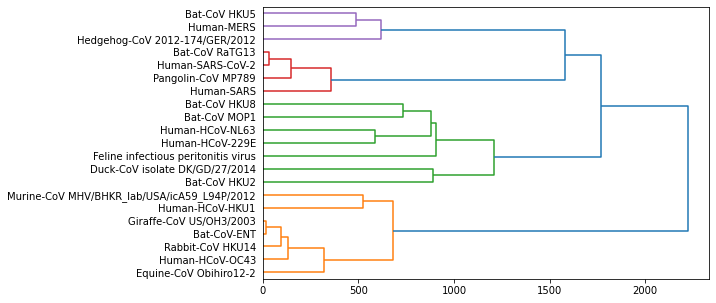

<Figure size 432x288 with 0 Axes>

In [7]:
from helper_functions import blosum62_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt

num_of_viruses = len(acid_seq)
distances_mat = [[0 for x in range(num_of_viruses)]for y in range(num_of_viruses)]
for i in range(num_of_viruses):
    for j in range(i):
        (seq1, seq2, score) = global_alignment(acid_seq[i], acid_seq[j], blosum62_score)
        for k in range(len(seq1)):
            if seq1[k] != seq2[k]:
                distances_mat[i][j] += 1
                distances_mat[j][i] += 1                   
z = linkage(squareform(distances_mat), 'ward')
fig = plt.figure(figsize=(8,5))
dendrogram(z, orientation='right',
            labels=[x for x in accession_codes],
            distance_sort='descending',
            show_leaf_counts=False)
plt.show()
plt.savefig('problem2.png')
phylogeny_comments = """
Did you notice anything interesting?

Other then two human and two bat coronaviruses being kinda similar based on clustering,
the dendogram doesn't really show similarities between coronaviruses of animals we deem similar. 
I think this is in some way interesting, as I expected species who are closer evolutionary to be clustered together earlier here aswell.
"""

# MiniBLAST

In the previous homework, your task was to find ORF candidates, which we then ran through NCBI's BLAST to find matching sequences in other organisms. Doing so, we were able to determine whether each ORF is a gene, and if it is a gene - what that gene does. In this homework, we will implement our own simplified version of BLAST, MiniBLAST.

*Disclaimer*: Obviously, BLAST is a complicated, state-of-the-art piece of technology, and the algorithms we will use here are not used in NCBI's BLAST at all. BLAST is highly optimized and uses heuristics to obtain (very good) approximate solutions and can query thousands of sequences in a matter of seconds. Our implementation will be slightly less sophisticated and slightly slower. However, the basic functionality and end result of this implementation will be conceptually the same as that of BLAST.

## Problem 3

**TASK:**
Implement the Smith-Waterman algorithm you learned about in lectures for local sequence alignment in the `local_alignment` function in `helper_functions.py`. You can verify your implementation against provided unit tests, but note that the unit tests may not be complete, but can serve as a guide in the right direction. Your code will be run against different and complete examples for grading. **[10 points]**

Once you have implemented local sequence alignment, proceed to Problem 4.

In [8]:
from helper_functions import local_alignment

## Problem 4

In the previous homework, we found ORF candidates in the SARS-CoV-2 genome and applied some filtering to reduce the number of ORFs we have to check. We then used NCBI's BLAST to find similar sequences in other organisms, which have already been annotated. We were then able to infer whether or not our ORF candidates were genes, and if they were, what they do. We would like to go through this process again, but this time, everyone from NCBI decided to go on a yearlong cruise around the world, and their servers just happened to go down with nobody to fix them. So we are left to fend for ourselves.

We have already run our ORF finder and, having applied some clever filtering, we have managed to narrow down our search to five ORFs. We will use our MiniBLAST implementation to test each of these ORFs to known, annotated sequences from three known coronaviruses, hoping to find a good match. A good match would mean that our ORF is most likely a gene, and since we know what the gene does in the reference virus, we will assume it does the same in SARS-CoV-2.

**TASK:**
We randomly pick three viruses, Human-SARS, Bat-CoV RaTG13, and Pangolin-CoV MP789 to use as reference genomes. You are given 5 ORFs from SARS-CoV-2 that we found in the previous homework. It is your job to determine their function i.e. what gene they code for. For each ORF, calculate the local alignment to all annotated protein sequences from the three reference genomes. Score each alignment by counting the number of matching symbols in the aligned sequences e.g. A-TT and A-GG has similarity 2 (similarily to Hamming distance, but reversed).

Save your answers into the `orf_matches` variable as indicated in the cell below. Each ORF should be assigned a *closest-organism*, indicating in which reference virus the closest match was found, as well as a *homologous-gene*, indicating which gene the ORF matched to. Note any interesting observations into the `orf_comments` variable.
**[10 points]**

In [9]:
reference_genomes = [
    "Human-SARS",
    "Bat-CoV RaTG13",
    "Pangolin-CoV MP789",
]
query = "Human-SARS-CoV-2"

First, we have to build up our reference database. To do this, look through all the coding regions (CDS) on each reference genome, extract it, and convert it to a protein sequence. Remember which gene each protein sequence belongs to, e.g. ORF1a, spike protein, ...

Here are you ORF candidates from SARS-CoV-2:

In [10]:
orf_candidates = {
    "ORF-1": (1, 11995, 13483),
    "ORF-2": (1, 26792, 27191),
    "ORF-3": (1, 23650, 25384),
    "ORF-4": (1, 9133, 13483),
    "ORF-5": (1, 25392, 26220),
}

In [11]:
from helper_functions import translate_to_protein
from helper_functions import blosum62_score
sequences = []
# extract cds type genomes translation and remember gene for each
for genome in reference_genomes:
    with Entrez.efetch(db="nucleotide", id=accession_codes[genome], rettype="gb") as handle:
        data = SeqIO.read(handle, "genbank")
    for feature in data.features:
        if feature.type == 'CDS':
            sequences.append((genome, feature.qualifiers['product'][0], feature.qualifiers['translation'][0]))
# get query sequence
with Entrez.efetch(db="nucleotide", id=accession_codes[query], rettype="gb") as handle:
    data = SeqIO.read(handle, "genbank")
    cov_seq = data.seq
# get protein ssequences for the given orfs
orf_sequences = {}
matches = {}
for orf in orf_candidates:
    orf_sequences[orf] = translate_to_protein(cov_seq[orf_candidates[orf][1]:orf_candidates[orf][2]])
    # calculate heighest score and assign reference virus and the gene type
    max_score = 0
    best_match = ()
    for genome in sequences:
        rev_hamming_score = 0
        aligned_seq1, aligned_seq2, score = local_alignment(genome[2], orf_sequences[orf], blosum62_score);
        for i in range(len(aligned_seq1)):
            if aligned_seq1[i] == aligned_seq2[i]:
                rev_hamming_score += 1
                
        if rev_hamming_score > max_score:
            max_score = rev_hamming_score
            best_match = (genome[0], genome[1])
    matches[orf] = best_match
print(matches)
orf_matches = {
    "ORF-1": {
        # These are just example solutions. You have to replace them with the correct answers
        "closest-organism": "Bat-CoV RaTG13", 
        "homologous-gene": "orf1ab polyprotein",
    },
    "ORF-2": {
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "membrane protein",
    },
    "ORF-3": {
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "spike glycoprotein",
    },
    "ORF-4": {
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "orf1ab polyprotein",
    },
    "ORF-5": {
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "nonstructural protein NS3",
    },
}
orf_comments = """
Did you notice anything interesting?

Probably the most interesting part of the results is the fact that Human-SARS-Cov-2
matched better with Bat-Cov than with Human-SARS using local alignment.
The similarity of those two also showed when we used global alignment for spike proteins(shown in above dendogram),
so it was not completely unexpected.
"""

{'ORF-1': ('Bat-CoV RaTG13', 'orf1ab polyprotein'), 'ORF-2': ('Bat-CoV RaTG13', 'membrane protein'), 'ORF-3': ('Bat-CoV RaTG13', 'spike glycoprotein'), 'ORF-4': ('Bat-CoV RaTG13', 'orf1ab polyprotein'), 'ORF-5': ('Bat-CoV RaTG13', 'nonstructural protein NS3')}


## Problem 4b - Bonus problem

In the previous problem, we saw that we were able to find very good matches for each of our ORFs. This is because our reference genomes were very closely related to SARS-CoV-2 (refer to the phylogenetic tree from problem 2). In this exercise, we will check if we can still recover the ORF identities, the same as in Problem 4, using three less-related reference genomes: Human-MERS, Bat-CoV HKU5, and Hedgehog-CoV 2012-174/GER/2012. Report your predictions in the `orf_bonus_matches` variable. Additionally, you should report how confident you are in each prediction. Use your creativity to score your confidence in each alignment. Write your justifications and other observations to the `orf_bonus_comments` variable.
**[5 points]**

In [12]:
reference_genomes = [
    "Human-MERS",
    "Bat-CoV HKU5",
    "Hedgehog-CoV 2012-174/GER/2012",
]
query = "Human-SARS-CoV-2"

In [13]:
orf_bonus_matches = {
    "ORF-1": {
        "closest-organism": "Bat-CoV HKU5", 
        "homologous-gene": "orf1ab polyprotein",
        "confidence": 3 # not confident: 1 -- 5 : completely confident
    },
    "ORF-2": {
        "closest-organism": "Bat-CoV HKU5",
        "homologous-gene": "membrane protein",
        "confidence": 2
    },
    "ORF-3": {
        "closest-organism": "Bat-CoV HKU5",
        "homologous-gene": "spike glycoprotein",
        "confidence": 2
    },
    "ORF-4": {
        "closest-organism": "Bat-CoV HKU5",
        "homologous-gene": "orf1ab polyprotein",
        "confidence": 3
    },
    "ORF-5": {
        "closest-organism": "Bat-CoV HKU5",
        "homologous-gene": "nonstructural protein NS3",
        "confidence": 2
    },
}
orf_bonus_comments = """
Did you notice anything interesting?

Because now the references are further apart from our query I assume their similarities to it will be more similar to each other then in the previous problem.
So it can happen that anyone of those three can apper for any of the proteins, but based on previous results
I predict Bat-Cov HKU5 to be the most similar to the Bat-Cov RaTG13 that we got in results for previous problem.  
"""

In [14]:
sequences2 = []
# extract cds type genomes translation and remember gene for each
for genome in reference_genomes:
    with Entrez.efetch(db="nucleotide", id=accession_codes[genome], rettype="gb") as handle:
        data = SeqIO.read(handle, "genbank")
    for feature in data.features:
        if feature.type == 'CDS':
            sequences2.append((genome, feature.qualifiers['product'][0], feature.qualifiers['translation'][0]))
matches2 = {}
for orf in orf_candidates:
    # calculate heighest score and assign reference virus and the gene type
    max_score = 0
    best_match = ()
    for genome in sequences2:
        rev_hamming_score = 0
        aligned_seq1, aligned_seq2, score = local_alignment(genome[2], orf_sequences[orf], blosum62_score);
        for i in range(len(aligned_seq1)):
            if aligned_seq1[i] == aligned_seq2[i]:
                rev_hamming_score += 1
                
        if rev_hamming_score > max_score:
            max_score = rev_hamming_score
            best_match = (genome[0], genome[1])
    matches2[orf] = best_match
print(matches2)

{'ORF-1': ('Hedgehog-CoV 2012-174/GER/2012', 'ORF1ab polyprotein'), 'ORF-2': ('Human-MERS', 'membrane protein'), 'ORF-3': ('Human-MERS', 'spike protein'), 'ORF-4': ('Hedgehog-CoV 2012-174/GER/2012', 'ORF1ab polyprotein'), 'ORF-5': ('Bat-CoV HKU5', 'ORF1ab polyprotein')}
